<a href="https://colab.research.google.com/github/JSini/keras/blob/main/Timeseries/timeseries_classification_FordA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Keras TimeSeries tutorial- https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

### Objective
The classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. 

#### FordA dataset from the UCR/UEA archive.
https://www.cs.ucr.edu/~eamonn/time_series_data_2018/

#### Dataset:
http://www.timeseriesclassification.com/description.php?Dataset=FordA

Each case consists of 500 measurements of engine noise and a classification. There are two separate problems: For FordA the Train and test data set were collected in typical operating conditions, with minimal noise contamination.

#### Article: Classification of Ford Motor Data
http://www.j-wichard.de/publications/FordPaper.pdf

###Importing libraries

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


###Data loading and preprocessing

In [2]:
def read_ucr(filename):
  data = np.loadtxt(filename, delimiter='\t')
  y = data[:, 0]
  X = data[:, 1:]
  return X, y.astype(int)

In [11]:
root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

In [12]:
X_train, y_train = read_ucr(root_url + "FordA_TRAIN.tsv")
X_test, y_test = read_ucr(root_url + "FordA_TEST.tsv")

Visualize the Data

Here we visualize one timeseries example for each class in the dataset.

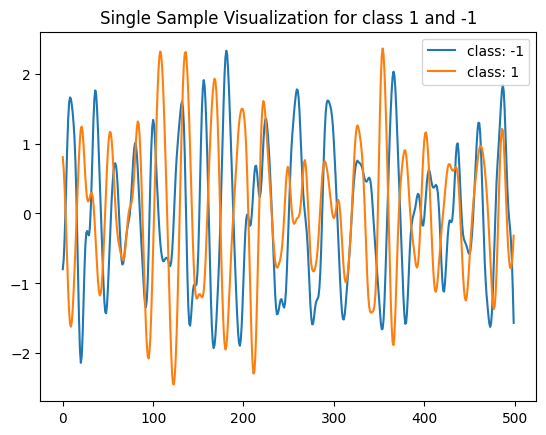

In [19]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
  X_train_c = X_train[y_train==c]
  plt.plot(X_train_c[0], label='class: '+str(c))
plt.legend(loc='best')
plt.title('Single Sample Visualization for class 1 and -1')
plt.show()
plt.close()

Standardizing Data

Note - data here is already z-normalized, each timeseries sample has a mean equal to zero and a standard deviation equal to one. This type of normalization is very common for timeseries classification problems

Reshaping Data

The timeseries data used here are univariate, meaning we only have one channel per timeseries example. We will therefore transform the timeseries into a multivariate one with one channel using a simple reshaping via numpy. This will allow us to construct a model that is easily applicable to multivariate time series.

In [21]:
type(X_train), X_train.shape

(numpy.ndarray, (3601, 500))

In [22]:
type(X_test), X_test.shape

(numpy.ndarray, (1320, 500))

In [23]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [24]:
type(X_train), X_train.shape

(numpy.ndarray, (3601, 500, 1))

In [25]:
type(X_test), X_test.shape

(numpy.ndarray, (1320, 500, 1))

Counting the unique classes we have

In [27]:
num_classes = len(np.unique(y_train))
num_classes

2

Shuffling the data

In [28]:
idx = np.random.permutation(len(X_train))

array([1184,   37, 3437, ...,  494,  402,  346])

In [29]:
X_train = X_train[idx]
y_train = y_train[idx]

Standardize the label to positive integers

In [30]:
y_train[y_train==-1] = 0
y_test[y_test==-1] = 0

###Building the model

In [31]:
X_train.shape

(3601, 500, 1)

In [32]:
X_train.shape[1:]

(500, 1)

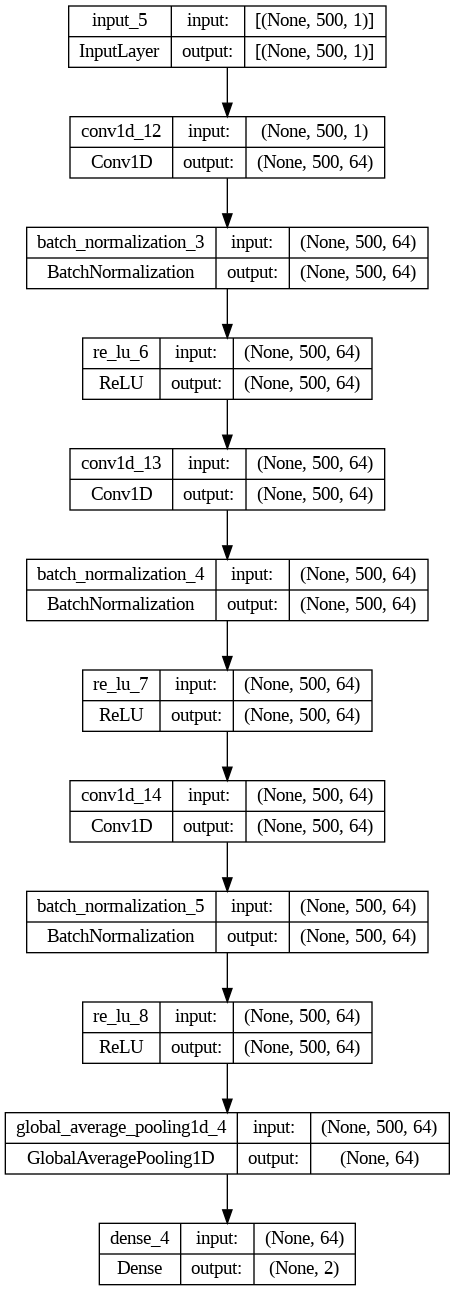

In [41]:
def make_model(input_shape):
  input_layer = keras.layers.Input(input_shape)

  #conv1 layer
  conv1 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='same')(input_layer)
  conv1 = keras.layers.BatchNormalization()(conv1)
  conv1 = keras.layers.ReLU()(conv1)

  #conv2 layer
  conv2 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='same')(conv1)
  conv2 = keras.layers.BatchNormalization()(conv2)
  conv2 = keras.layers.ReLU()(conv2)

  #conv3 layer
  conv3 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='same')(conv2)
  conv3 = keras.layers.BatchNormalization()(conv3)
  conv3 = keras.layers.ReLU()(conv3)


  pool  = keras.layers.GlobalAveragePooling1D()(conv3)

  output_layer = keras.layers.Dense(num_classes, activation="softmax")(pool)

  return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)
  

### Train the model

In [42]:
epochs = 200
batch_size = 32

checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
lr_reg = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1)

callbacks = [checkpoint, lr_reg, early_stop]

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)


history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/200
90/90 [==============================] - 15s 153ms/step - loss: 0.5502 - sparse_categorical_accuracy: 0.7236 - val_loss: 0.7380 - val_sparse_categorical_accuracy: 0.4730 - lr: 0.0010
Epoch 2/200
90/90 [==============================] - 16s 180ms/step - loss: 0.4233 - sparse_categorical_accuracy: 0.7972 - val_loss: 0.8262 - val_sparse_categorical_accuracy: 0.4730 - lr: 0.0010
Epoch 3/200
90/90 [==============================] - 22s 244ms/step - loss: 0.4092 - sparse_categorical_accuracy: 0.7993 - val_loss: 0.7733 - val_sparse_categorical_accuracy: 0.4730 - lr: 0.0010
Epoch 4/200
90/90 [==============================] - 17s 193ms/step - loss: 0.3703 - sparse_categorical_accuracy: 0.8260 - val_loss: 0.9521 - val_sparse_categorical_accuracy: 0.4730 - lr: 0.0010
Epoch 5/200
90/90 [==============================] - 22s 242ms/step - loss: 0.3550 - sparse_categorical_accuracy: 0.8326 - val_loss: 0.7162 - val_sparse_categorical_accuracy: 0.5895 - lr: 0.0010
Epoch 6/200
90/90 [======

### Model Evaluation

In [43]:
model = keras.models.load_model('/content/best_model.h5')
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test accuracy", test_accuracy)
print("Test loss", test_loss)

42/42 [==============================] - 1s 29ms/step - loss: 0.2056 - sparse_categorical_accuracy: 0.9114
Test accuracy 0.9113636612892151
Test loss 0.20563235878944397


Plot model training and validation loss

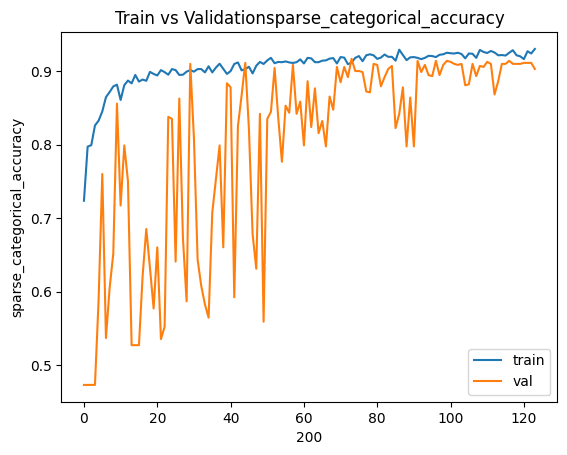

In [44]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('Train vs Validation' + metric)
plt.ylabel(metric)
plt.xlabel(epochs)
plt.legend(['train', 'val'], loc='best')
plt.show()